In [1]:
import sys
sys.path.append('../src')
import QuasarPy as Q

import numpy as np
import seaborn as sns
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# quasar path pulled from environment
print("Quasar Path:", Q.get_quasar_exec())

Quasar Path: C:\Program Files\ODYSSEE\CAE\QuasarEngine_2.exe


          param_1     param_2
count  128.000000  128.000000
mean     1.000000    1.000000
std      0.584165    0.584165
min      0.000000    0.000000
25%      0.500000    0.500000
50%      1.000000    1.000000
75%      1.500000    1.500000
max      2.000000    2.000000
CPU times: total: 375 ms
Wall time: 3.17 s


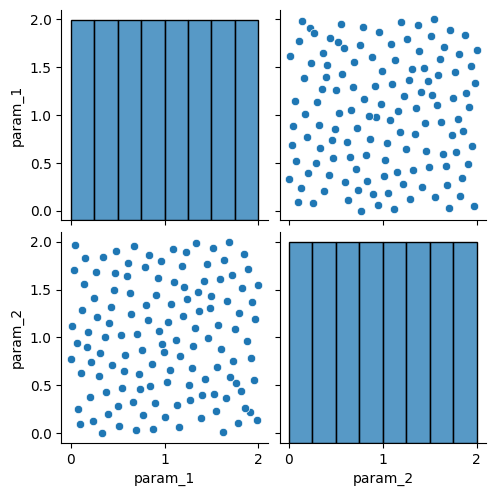

In [2]:
%%time
# Create Training Data
num = 128
seed = 117
mat_MINMAX = [
    ['param_1', 0, 2],
    ['param_2', 0, 2]
] # labels aren't necessary and won't be returned, using here to label output dataframe
out = Q.DOE_generation('optimal_latin_hypercube', num, seed, mat_MINMAX)
if out is None:
    print(Q.get_quasar_out())
else:
    df = pd.DataFrame(out, columns=[x[0] for x in mat_MINMAX])
    print(df.describe())
    sns.pairplot(df)

X_TRAIN = df.values
Y_TRAIN = np.sin(X_TRAIN[:,0]**2 + X_TRAIN[:,1]**2)

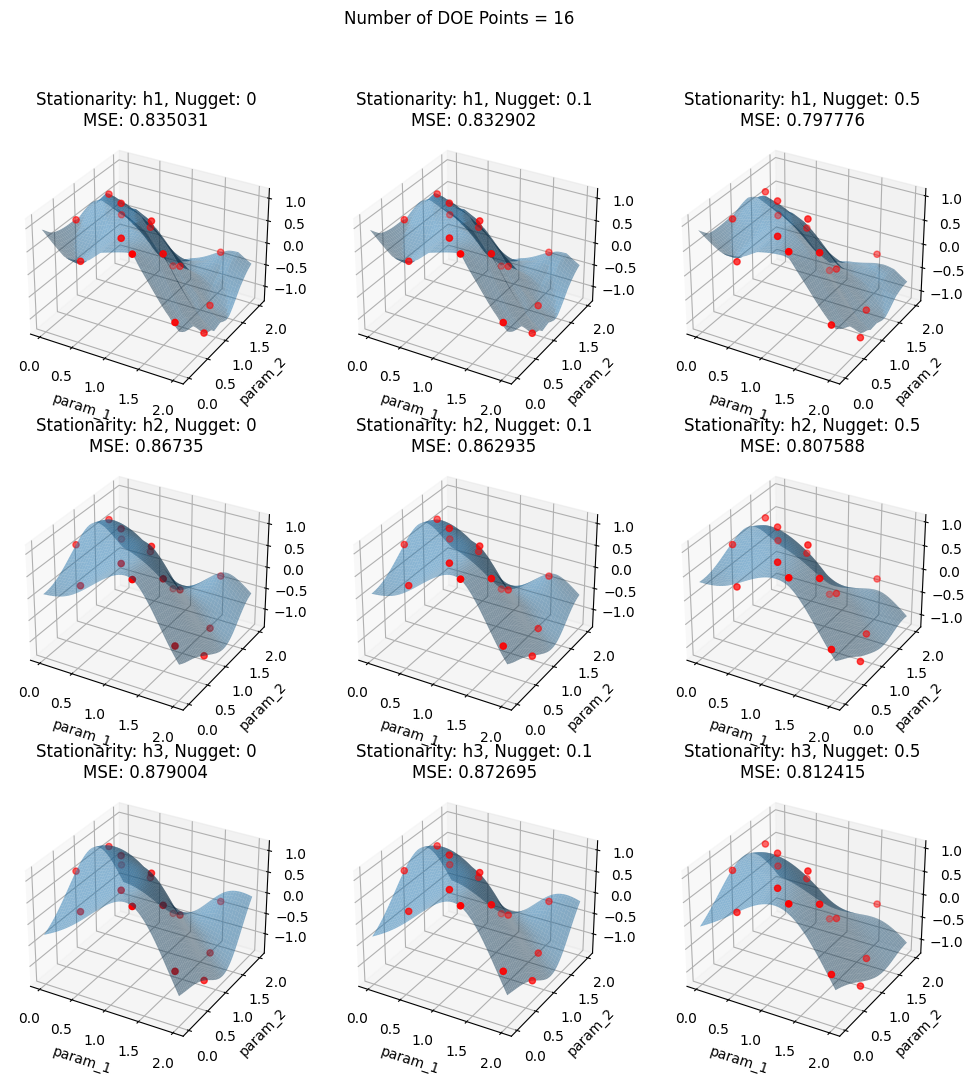

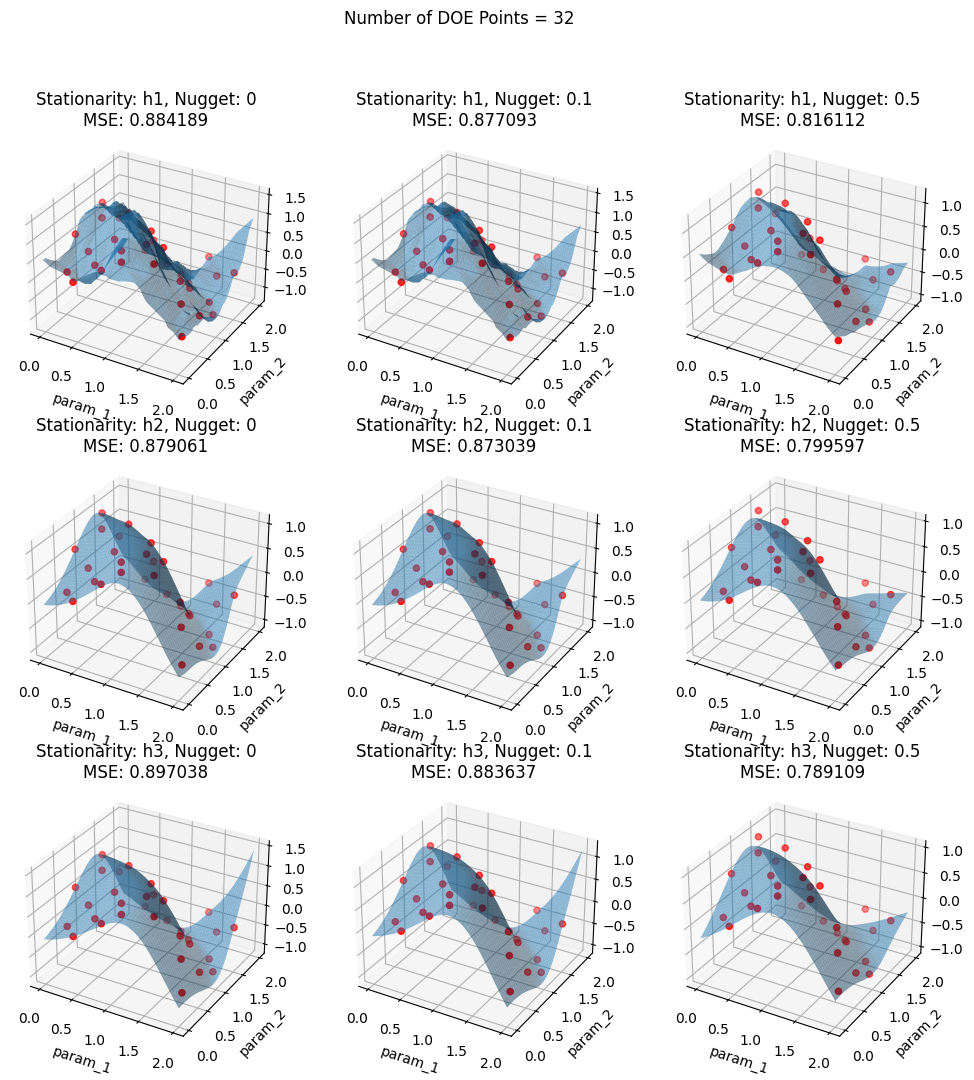

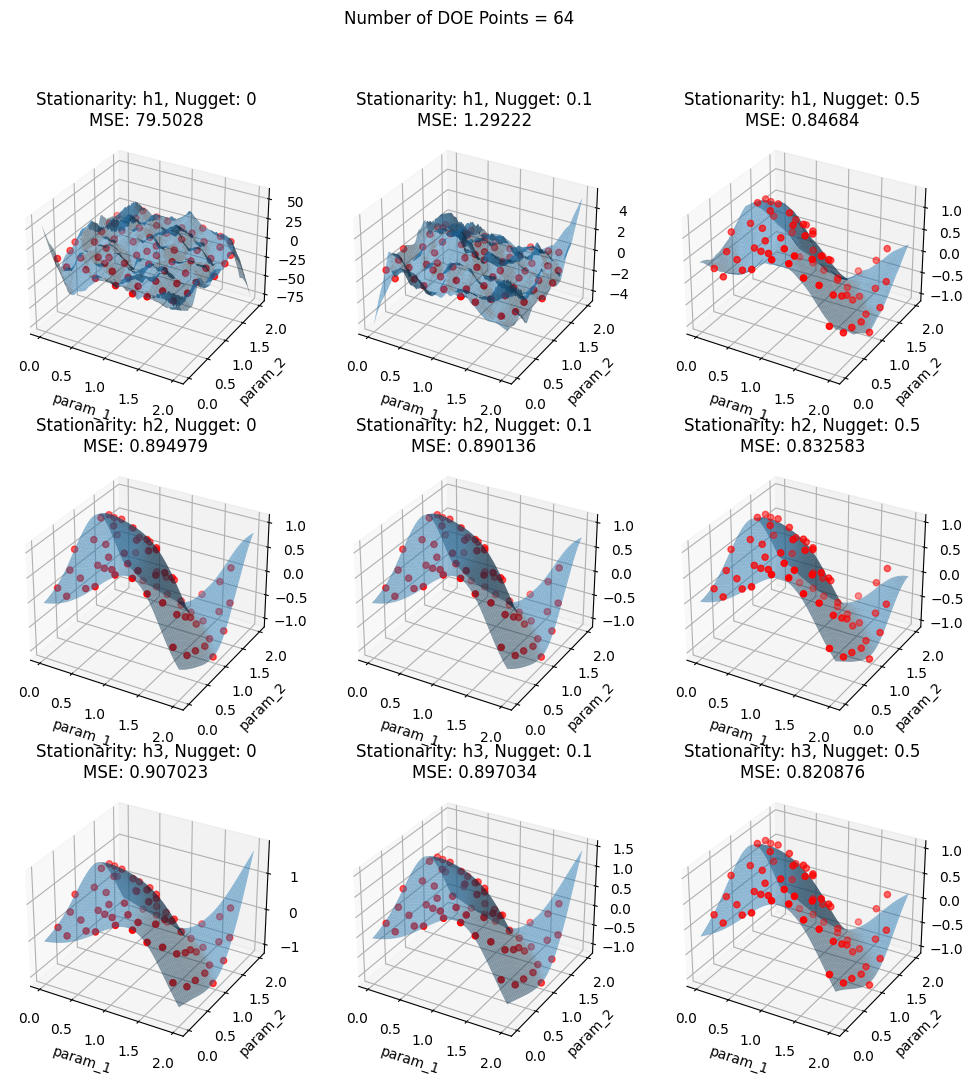

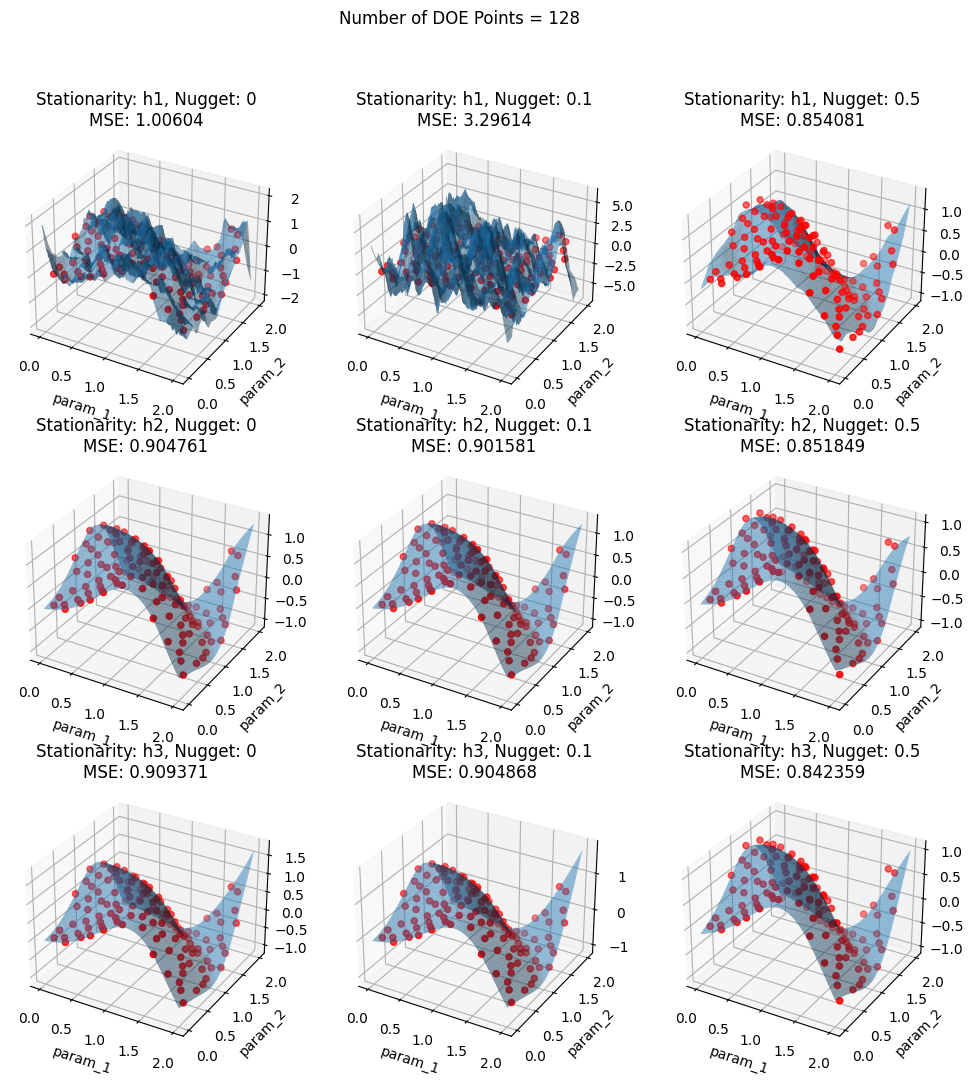

In [3]:
for N_DOE in [16, 32, 64, 128]:
    # Create Training DOE
    seed = 117
    mat_MINMAX = [
        ['param_1', 0, 2],
        ['param_2', 0, 2]
    ] # labels aren't necessary and won't be returned, using here to label output dataframe
    out = Q.DOE_generation('optimal_latin_hypercube', N_DOE, seed, mat_MINMAX)
    if out is not None:
        df = pd.DataFrame(out, columns=[x[0] for x in mat_MINMAX])
    else:
        print('Error with N_DOE = %d' % N_DOE)
        continue

    # Create Training Data (Y-Values)
    X_TRAIN = df.values
    Y_TRAIN = np.sin(X_TRAIN[:,0]**2 + X_TRAIN[:,1]**2)

    # Predict using Quasar on full space for plotting
    N_pts = 100
    X_PLOT = np.meshgrid(np.linspace(0,2,N_pts), np.linspace(0,2,N_pts)) 
    X_PLOT_reformat = np.vstack((np.hstack(X_PLOT[0]), np.hstack(X_PLOT[1]))).T
    Y_exact = np.sin(X_PLOT_reformat[:,0]**2 + X_PLOT_reformat[:,1]**2)

    fig = plt.figure(figsize=(12,12))

    for n, StationaryFunction in enumerate(['h1', 'h2', 'h3']):
        for m, Nugget in enumerate([0.0, 0.1, 0.5]):
            ax = fig.add_subplot(3, 3, 3*n + m + 1, projection='3d')
            Y_PLOT_reformat = Q.POD_kriging(X_TRAIN, Y_TRAIN, X_PLOT_reformat, StationarityFunction=StationaryFunction, NuggetEffect=Nugget)

            if Y_PLOT_reformat is not None:
                ax.plot_surface(X_PLOT[0], X_PLOT[1], Y_PLOT_reformat.reshape((N_pts,N_pts)), alpha=0.5)
                ax.scatter(X_TRAIN[:,0], X_TRAIN[:,1], Y_TRAIN, c='r')
                ax.set_xlabel(df.columns[0])
                ax.set_ylabel(df.columns[1])
                ax.set_title('Stationarity: %s, Nugget: %g\nMSE: %g' % (StationaryFunction, Nugget, np.mean((Y_exact-Y_PLOT_reformat)**2)), pad=-10)

            else:
                ax.set_title('ERROR\nStationarity: %s, Nugget: %g' % (StationaryFunction, Nugget))

    # plt.tight_layout()
    plt.suptitle('Number of DOE Points = %d' % N_DOE)
    plt.show()
